# Fine Tuning MobileNetV2 terhadap dataset Clothing 10.000

Berikut adalah jupyter notebook untuk fine tuning terhadap arsitektur MobileNetV2 tersebut supaya bisa digunakan untuk memprediksi dataset Clothing 10.000.

## Clothing 10.000

Clothing 10.000 adalah sebuah dataset yang dikumpulkan oleh penelitin dengan melakukan proses pengumpulan gambar-gambar dari situs e-commerce secara manual. Dataset ini terdiri dari 10 kelas, masing-masing terdiri dari 1.000 data untuk training dan 250 data untuk testing. Total terdiri dari 12.500 data.

## Langkah Fine Tuning

Secara garis besar, berikut adalah langkah fine tuning yang dilakukan pada penelitian ini:
1. Image augmentation untuk data training dan validation
2. Instansiasi arsitektur model asli dari keras, dan menghilangkan top layer-nya
3. Menambahkan beberapa layer untuk menggantikan top layer model asli
4. Set-up fine tuning
5. Training model
6. Testing model

Berikut langkah-langkah tersebut

In [1]:
import os, sys, glob, datetime, time, pytz

from keras import __version__

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

Using TensorFlow backend.


In [2]:
# Defining variables
EPOCHS        = 100
BAT_SIZE      = 20
FROZEN_LAYERS = 155 # 2 blok terakhir
DATA_SET_DIR  = '/home/jupyter/clothing-dataset/data/' # clothing dataset 10.000

WIDTH, HEIGHT = 224, 224
FC_SIZE       = 256

TRAIN_DIR        = DATA_SET_DIR + 'train'
TEST_DIR         = DATA_SET_DIR + 'test'
nb_classes       = len(glob.glob(TRAIN_DIR + "/*"))

timezone = pytz.timezone("Asia/Jakarta")

now = timezone.localize(datetime.datetime.now())

## 1. Image augmentation untuk data training dan validation

Di bawah ini adalah langkah pertama yang dilakukan.

Found 8000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Training Sample


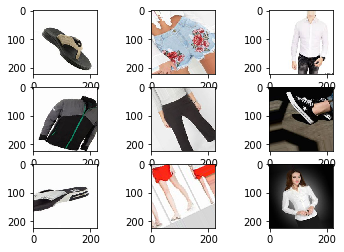

Validation Sample


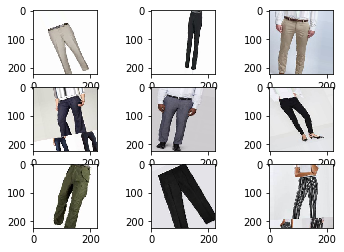

In [3]:
from keras.preprocessing.image import ImageDataGenerator
# from keras.applications.inception_v3 import preprocess_input

train_datagen =  ImageDataGenerator(
#     preprocessing_function=preprocess_input,
    rescale=1.0/255.0,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# test_datagen = ImageDataGenerator(
#     rescale=1.0/255.0,
#     rotation_range=30,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True
# )

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(WIDTH, HEIGHT),
    batch_size=BAT_SIZE,
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(WIDTH, HEIGHT),
    batch_size=BAT_SIZE,
    subset='validation',
    shuffle=False
)

# test_generator = test_datagen.flow_from_directory(
#     TEST_DIR,
#     target_size=(WIDTH, HEIGHT),
#     batch_size=BAT_SIZE,
#     shuffle=False
# )

print('Training Sample')
x,y = train_generator.next()
for i in range(0,9):
    plt.subplot(330 + 1 + i)
    image = x[i]
    plt.imshow(image)

plt.show()

print('Validation Sample')
x,y = validation_generator.next()
for i in range(0,9):
    plt.subplot(330 + 1 + i)
    image = x[i]
    plt.imshow(image)

plt.show()

## 2. Instansiasi arsitektur model asli dari keras, dan menghilangkan top layer-nya

Berikutnya adalah instansiasi arsitektur model asli. Model aslinya sendiri sudah tersedia secara built-in di dalam keras. Maka dari itu proses instansiasi-nya menjadi sangat sederhana.

Berikut adalah proses instansiasi tersebut

In [4]:
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.utils.vis_utils import plot_model

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(WIDTH, HEIGHT, 3))

print('Model asli tanpa top layer terdiri dari %d layer' % len(base_model.layers))
# base_model.summary()
# plot_model(base_model, to_file='MobileNetV2_plot.png', show_shapes=True, show_layer_names=True)
# sys.exit()

W0720 08:01:24.243504 140409748653824 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0720 08:01:24.280805 140409748653824 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0720 08:01:24.287291 140409748653824 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0720 08:01:24.315144 140409748653824 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0720 08:01:24.316086 1404097486

9412608/9406464 [==============================] - 9s 1us/step
Model asli tanpa top layer terdiri dari 155 layer


## 3. Menambahkan beberapa layer untuk menggantikan top layer MobileNet

Pada instansiasi di langkah sebelumnya layer classifier atau layer paling atas tida diikut sertakan. Maka pada langkah ini akan dibuat layer baru yang digunakan sebagai pengganti layer MobileNet yang tidak diikut sertakan.

Berikut adalah langkah tersebut

In [5]:
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.models import Model

x = base_model.output

x = GlobalAveragePooling2D()(x)
x = Dense(FC_SIZE, activation='relu')(x) #new FC layer, random init
x = Dropout(0.5)(x)
classifier = Dense(nb_classes, activation='softmax')(x) #new softmax layer

model = Model(inputs=base_model.input, outputs=classifier)

print('Model baru terdiri dari %d layer' % (len(model.layers)))

W0720 08:01:47.014794 140409748653824 deprecation.py:506] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model baru terdiri dari 159 layer


## 4. Set-up fine tuning

Langkah ini dilakukan untuk menentukan layer mana saja yang akan ditraining dan tidak ditraining.

Berikut adalah langkahnya.

In [6]:
from keras.optimizers import SGD
from keras.metrics import top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

for layer in model.layers[:FROZEN_LAYERS]:
    layer.trainable = False
for layer in model.layers[FROZEN_LAYERS:]:
    layer.trainable = True

model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy', top_3_accuracy, 'top_k_categorical_accuracy'])
model.summary()

W0720 08:01:47.088171 140409748653824 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

## 5. Training model

Langkah berikutnya adalah training model yang telah di set-up pada langkah sebelumnya.

Berikut adalah langkahnya

In [7]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from sklearn.metrics import classification_report, confusion_matrix

training_start_datetime = timezone.localize(datetime.datetime.now()).strftime("%Y-%m-%d %H:%M:%S")
start = time.time()
history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples // BAT_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps = validation_generator.samples // BAT_SIZE,
    callbacks=[CSVLogger('/home/jupyter/MobileNetV2.log')]
)
end = time.time()
training_end_datetime = timezone.localize(datetime.datetime.now()).strftime("%Y-%m-%d %H:%M:%S")
print('Training from %s to %s taking %d seconds.' % (training_start_datetime, training_end_datetime, (end - start)))

W0720 08:01:47.704882 140409748653824 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
400/400 [==============================] - 142s 354ms/step - loss: 2.4138 - acc: 0.1459 - top_3_accuracy: 0.3893 - top_k_categorical_accuracy: 0.5936 - val_loss: 2.0931 - val_acc: 0.2405 - val_top_3_accuracy: 0.5450 - val_top_k_categorical_accuracy: 0.7485
Epoch 2/100
400/400 [==============================] - 136s 340ms/step - loss: 2.0728 - acc: 0.2563 - top_3_accuracy: 0.5541 - top_k_categorical_accuracy: 0.7481 - val_loss: 1.8271 - val_acc: 0.3750 - val_top_3_accuracy: 0.6955 - val_top_k_categorical_accuracy: 0.8700
Epoch 3/100
400/400 [==============================] - 135s 338ms/step - loss: 1.8797 - acc: 0.3463 - top_3_accuracy: 0.6463 - top_k_categorical_accuracy: 0.8150 - val_loss: 1.6498 - val_acc: 0.4460 - val_top_3_accuracy: 0.7680 - val_top_k_categorical_accuracy: 0.9040
Epoch 4/100
400/400 [==============================] - 135s 339ms/step - loss: 1.7322 - acc: 0.4000 - top_3_accuracy: 0.7190 - top_k_categorical_accuracy: 0.8610 - val_loss: 1.5167 - val_acc: 0

## 6. Testing model

Langkah berikutnya adalah testing menggunakan dataset testing.

Berikut adalah langkahnya

In [8]:
# Testing
# testing_start_datetime = timezone.localize(datetime.datetime.now()).strftime("%Y-%m-%d %H:%M:%S")
# testing_start = time.time()
# Y_pred = model.predict_generator(
#     test_generator, 
#     steps=test_generator.samples // BAT_SIZE,
#     verbose=1
# )
# testing_end = time.time()
# testing_end_datetime = timezone.localize(datetime.datetime.now()).strftime("%Y-%m-%d %H:%M:%S")
# print('Testing from %s to %s taking %d seconds.' % (testing_start_datetime, testing_end_datetime, (testing_end - testing_start)))

## Langkah Tambahan: Simpan model

In [9]:
# Simpan arsitektur dan weight dari model yang telah di training ke sebuah file
# File tersebut selanjutnya digunakan untuk prediksi data atau gambar
# model_save_time = now.strftime("%Y_%m_%d_%H_%M")
model.save('MobileNetV2.model')
print('Model tersimpan')

Model tersimpan


## Langkah tambahan: Tampilkan accuracy, loss, confusion matrix serta classification report

Langkah ini dilakukan untuk menampilkan kurva accuracy dan loss dari training yang telah dilakukan. Serta confusion matrix untuk testing. Selain itu detail laporan terkait precision, f-score dan recall juga ditampilkan di sini.

Berikut adalah langkahnya

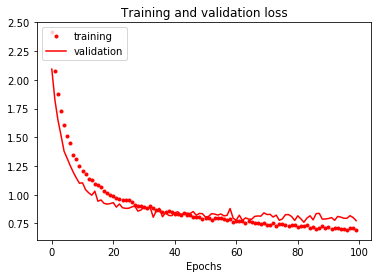

In [10]:
# %matplotlib inline

# import matplotlib.pyplot as plt
import itertools
from sklearn.utils.multiclass import unique_labels

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

# Accuracy
plt.plot(epochs, acc, 'r.', label='training')
plt.plot(epochs, val_acc, 'r', label='validation')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.legend(loc='upper left')
plt.show()

# Loss
plt.plot(epochs, loss, 'r.', label='training')
plt.plot(epochs, val_loss, 'r-', label='validation')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.legend(loc='upper left')
plt.show()

# Confusion Matrix
# y_pred = np.argmax(Y_pred, axis=1)
# cm = confusion_matrix(test_generator.classes, y_pred)
# classes = sorted(os.listdir(TEST_DIR))
# plt.figure(figsize=(12,8))
# plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
# plt.title('Confusion matrix')
# plt.colorbar()
# tick_marks = np.arange(len(classes))
# plt.xticks(tick_marks, classes, rotation=45)
# plt.yticks(tick_marks, classes)

# fmt = 'd'
# thresh = cm.max() / 2.
# for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#     plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

# plt.tight_layout()
# plt.ylabel('True label')
# plt.xlabel('Predicted label')
# plt.show()

# print('Classification Report')
# classification_report = classification_report(test_generator.classes, y_pred, target_names=classes)
# print(classification_report)